# Blackjack Environment with Complete Point-Count System

This cell sets up the Blackjack environment, which includes the card counting system.


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

class BlackjackEnv:
    def __init__(self):
        self.deck = self.init_deck()
        self.player_hand = []
        self.dealer_hand = []
        self.split_hand = []
        self.doubled = False
        self.rewards = []
        self.hand_lengths = []
        self.running_count = 0
        self.reset_game()

    def init_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        ranks = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = [str(rank) + '_' + suit for rank in ranks for suit in suits]
        random.shuffle(deck)
        return deck

    def draw_card(self):
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        self.update_running_count(card)
        return card

    def reset_game(self):
        self.deck = self.init_deck()
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.running_count = 0

    def update_running_count(self, card):
        rank = card.split('_')[0]
        if rank in ['2', '3', '4', '5', '6']:
            self.running_count += 1
        elif rank in ['10', 'jack', 'queen', 'king', 'ace']:
            self.running_count -= 1

    def get_card_value(self, card):
        rank = card.split('_')[0]
        if rank in ['jack', 'queen', 'king']:
            return 10
        elif rank == 'ace':
            return 11
        else:
            return int(rank)

    def hand_value(self, hand):
        value = sum(self.get_card_value(card) for card in hand)
        if value > 21 and any(card.startswith('ace') for card in hand):
            value -= 10
        return value

    def is_soft_hand(self, hand):
        return any(card.startswith('ace') for card in hand) and self.hand_value(hand) <= 21

    def is_busted(self, hand):
        return self.hand_value(hand) > 21

    def dealer_play(self):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.draw_card())

    def is_pair(self, hand):
        return len(hand) == 2 and hand[0].split('_')[0] == hand[1].split('_')[0]

    def step(self, action):
        if action == 'hit':
            self.player_hand.append(self.draw_card())
            if self.is_busted(self.player_hand):
                self.rewards.append(-1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', -2 if self.doubled else -1, True
        elif action == 'stand':
            self.dealer_play()
            player_value = self.hand_value(self.player_hand)
            dealer_value = self.hand_value(self.dealer_hand)
            if self.is_busted(self.dealer_hand) or player_value > dealer_value:
                self.rewards.append(1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', 1, True
            elif dealer_value > player_value:
                self.rewards.append(-1)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', -1, True
            else:
                self.rewards.append(0)
                self.hand_lengths.append(len(self.player_hand))
                return 'terminal', 0, True

        elif action == 'split' and self.is_pair(self.player_hand):
            self.split_hand = [self.player_hand.pop()]
            self.player_hand.append(self.draw_card())
            self.split_hand.append(self.draw_card())
            return self.get_state(), 0, False

        elif action == 'double':
            self.doubled = True
            self.player_hand.append(self.draw_card())
            if self.is_busted(self.player_hand):
                return 'terminal', -2, True
            return self.get_state(), 0, False

        return self.get_state(), 0, False

    def get_state(self):
        return (
            self.hand_value(self.player_hand),
            self.get_card_value(self.dealer_hand[0]),
            self.is_soft_hand(self.player_hand),
            len(self.split_hand) > 0,
            self.doubled,
            self.running_count
        )


# Q-Learning Agent with Complete Point-Count System




In [2]:
class QLearningAgent:
    def __init__(self, env, episodes, start_epsilon, decay_epsilon, min_epsilon, learning_rate=0.1, discount=0.99):
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount
        self.epsilon = start_epsilon
        self.total_episodes = episodes
        self.epsilon_decay = decay_epsilon
        self.min_epsilon = min_epsilon
        self.Q = defaultdict(float)
        self.errors = []
        self.episode_rewards = []

    def get_q_value(self, state, action):
        return self.Q.get((state, action), 0)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(['hit', 'stand'])
        else:
            return max(['hit', 'stand'], key=lambda action: self.get_q_value(state, action))

    def update_q_value(self, state, action, next_state, reward):
        current_q = self.get_q_value(state, action)
        next_q = max(self.get_q_value(next_state, a) for a in ['hit', 'stand'])
        td_error = reward + self.gamma * next_q - current_q
        self.Q[(state, action)] = current_q + self.alpha * td_error
        self.errors.append(td_error)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

    def train(self):
        for episode in range(self.total_episodes):
            self.env.reset_game()
            state = self.env.get_state()
            done = False
            total_reward = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_value(state, action, next_state, reward)
                state = next_state
                total_reward += reward
            self.episode_rewards.append(total_reward)
            self.decay_epsilon()

    def evaluate(self, num_games=1000):
        win, loss, tie = 0, 0, 0
        for _ in range(num_games):
            self.env.reset_game()
            state = self.env.get_state()
            done = False
            while not done:
                action = max(['hit', 'stand'], key=lambda action: self.get_q_value(state, action))
                state, reward, done = self.env.step(action)
            if reward > 0:
                win += 1
            elif reward < 0:
                loss += 1
            else:
                tie += 1
        return win, loss, tie


## Training the Agent

The agent is trained for 100000 episodes to learn the optimal policy.


In [ ]:
# Training the Agent
episodes = 100000
start_epsilon = 1.0
decay_epsilon = start_epsilon / (episodes / 2)
min_epsilon = 0.1

environment = BlackjackEnv()
agent = QLearningAgent(environment, episodes, start_epsilon, decay_epsilon, min_epsilon)

agent.train()


## Evaluating the Agent

The agent's performance is evaluated by playing 10000 games and calculating the win rate.


In [ ]:
# Evaluating the Agent
wins, losses, ties = agent.evaluate(num_games=10000)
total_games = wins + losses + ties
win_rate = (wins / total_games) * 100
loss_rate = (losses / total_games) * 100
tie_rate = (ties / total_games) * 100

print(f"Evaluation results: {wins} wins, {losses} losses, {ties} ties")
print(f"Win rate: {win_rate:.2f}%, Loss rate: {loss_rate:.2f}%, Tie rate: {tie_rate:.2f}%")

Evaluation results: 4308 wins, 4835 losses, 857 ties
Win rate: 43.08%, Loss rate: 48.35%, Tie rate: 8.57%


# Episode Rewards Plot

This plot shows the moving average of the episode rewards over time.


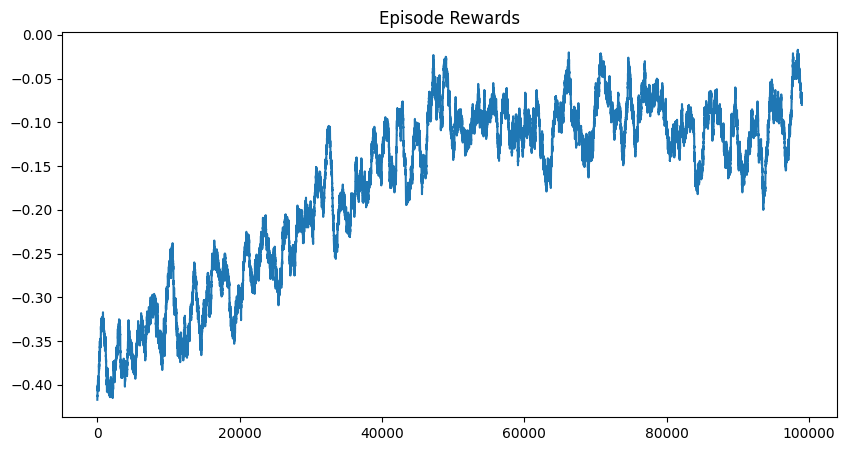

In [ ]:
# Episode Rewards Plot
length_step = 1000
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Episode Rewards')
reward_moving_average = (np.convolve(np.array(agent.episode_rewards).flatten(), np.ones(length_step) / length_step, mode="valid"))
ax.plot(range(len(reward_moving_average)), reward_moving_average)
plt.show()


# Policy Grid Plots

These plots show the learned policy for soft and hard hands.


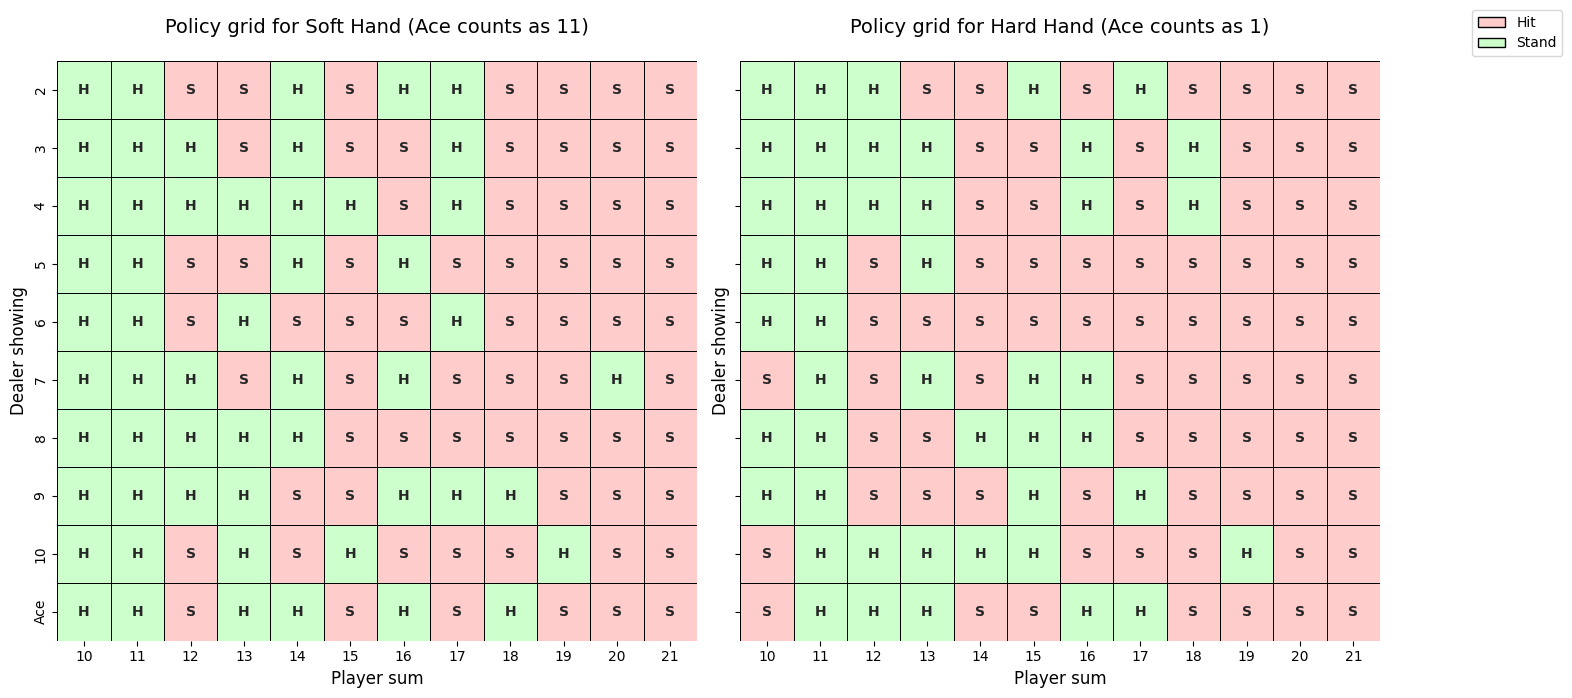

In [ ]:
from matplotlib.patches import Patch

def create_policy_grid(agent, soft=True):
    policy = defaultdict(int)
    for state_action in agent.Q.keys():
        state, action = state_action
        is_soft = state[2]
        if (soft and is_soft) or (not soft and not is_soft):
            state_key = (state[0], state[1], state[2], state[3], state[4])
            policy[state_key] = 'H' if max(['hit', 'stand'], key=lambda a: agent.Q.get((state, a), 0)) == 'hit' else 'S'

    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))
    policy_grid = np.apply_along_axis(lambda state: policy.get((state[0], state[1], soft, False, False), 'H'), axis=2, arr=np.dstack([player_count, dealer_count]))

    return policy_grid

def plot_policy_grids(policy_grid_soft, policy_grid_hard):
    player_count, dealer_count = np.meshgrid(np.arange(10, 22), np.arange(2, 12))

    fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharey=True)

    sns.heatmap(policy_grid_soft == 'H', linewidth=0.5, annot=policy_grid_soft, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[0], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[0].set_title("Policy grid for Soft Hand (Ace counts as 11)", fontsize=14, pad=20)
    axs[0].set_xlabel("Player sum", fontsize=12)
    axs[0].set_ylabel("Dealer showing", fontsize=12)
    axs[0].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[0].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    sns.heatmap(policy_grid_hard == 'H', linewidth=0.5, annot=policy_grid_hard, fmt='', cmap=['#ffcccc', '#ccffcc'], cbar=False, ax=axs[1], linecolor='black', annot_kws={"size": 10, "weight": "bold"})
    axs[1].set_title("Policy grid for Hard Hand (Ace counts as 1)", fontsize=14, pad=20)
    axs[1].set_xlabel("Player sum", fontsize=12)
    axs[1].set_ylabel("Dealer showing", fontsize=12)
    axs[1].set_xticklabels(np.arange(10, 22), fontsize=10)
    axs[1].set_yticklabels([2, 3, 4, 5, 6, 7, 8, 9, 10, "Ace"], fontsize=10)

    legend_elements = [Patch(facecolor="#ffcccc", edgecolor="black", label="Hit"), Patch(facecolor="#ccffcc", edgecolor="black", label="Stand")]
    fig.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

policy_grid_soft = create_policy_grid(agent, soft=True)
policy_grid_hard = create_policy_grid(agent, soft=False)

plot_policy_grids(policy_grid_soft, policy_grid_hard)
